In [1]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from collections import Counter



### Choose Model
These parameters need to be changed to create the different coefficient matrices and accuracies

In [2]:
weights = True
no_AQI = True

PATH = ""
if(no_AQI):
   
    if(weights):
        from LSTM_training_weights_no_EAQI import LSTM_Model, SeqDataset, create_windows
        PATH = 'params_weights_no_EAQI.pt'
    else:
        from LSTM_training import LSTM_Model, SeqDataset, create_windows
        PATH = 'params_no_EAQI.pt'
else:
    from LSTM_training import LSTM_Model, SeqDataset, create_windows
    if(weights):
        PATH = "params_weights.pt"
    else:
        PATH = "params.pt"

### Overview EAQI

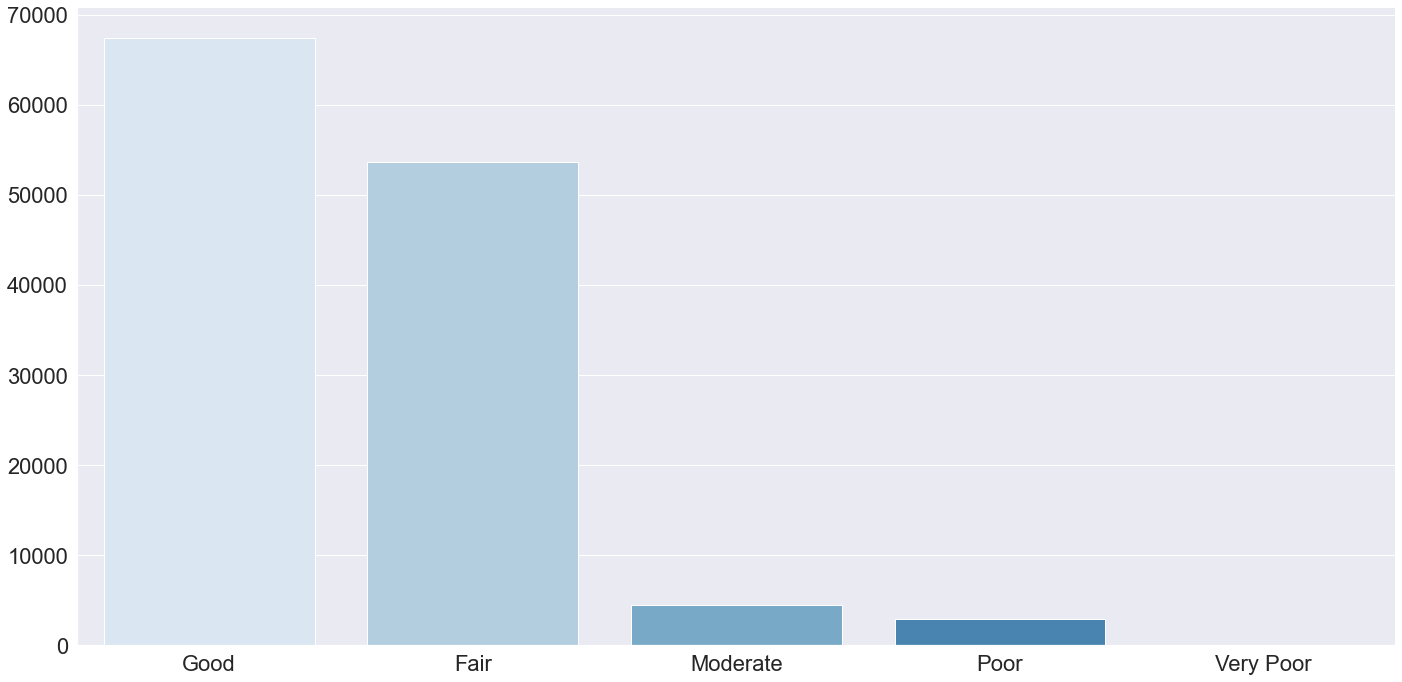

In [3]:

X_labels = ['Zweirad', 'Personenwagen', 'Lastwagen', 'Hr', 'RainDur', 'T', 'WVs', 'StrGlo', 'p', "AQI"] 
y_label = "AQI"

data = pd.read_csv('../processed_data/full_data_imputed_with_EAQI.csv')


aqi = data[y_label]
aqi2 = data.groupby(y_label).count()["Jahr"].to_numpy()
aqi_df = pd.DataFrame([list(aqi2)], columns = ["Good","Fair","Moderate","Poor", "Very Poor"])
sns.set(font_scale=2)
sns.catplot(data = aqi_df, kind="bar", palette="Blues", height=10, aspect=20/10)


### Set up the test data (2021)

In [4]:
X_labels = ['Zweirad', 'Personenwagen', 'Lastwagen', 'Hr', 'RainDur', 'T', 'WVs', 'StrGlo', 'p'] 
y_label = "AQI"

data = pd.read_csv('../processed_data/full_data_imputed_with_EAQI.csv')

data = data.loc[data["Jahr"]== 2021]

X_data = data[X_labels]
y_data = data[y_label]
X, y = create_windows(X_data, y_data, 48)

test_data = SeqDataset(X, y)

loaded_data = DataLoader(test_data, batch_size=1, shuffle=False)


### Get predictions of model for 2021


In [5]:
model = LSTM_Model()
model.load_state_dict(torch.load(PATH))

model = model.to(torch.double)

model.eval()

y_pred = []
y_true = []
with torch.no_grad():
    for j, (xi, yi) in enumerate(loaded_data):
        y_predicted = model(xi)
        y_pred.append(np.argmax(y_predicted.numpy()))
        y_true.append(np.argmax(yi.numpy()))
        
print(Counter(y_pred))

score = accuracy_score(y_true, y_pred)
print(score)

Counter({0: 7248, 1: 1320, 3: 78, 2: 35})
0.7464577813615942


### Create confusion matrix

Text(0.5, 62.249999999999986, 'Predicted EAQI')

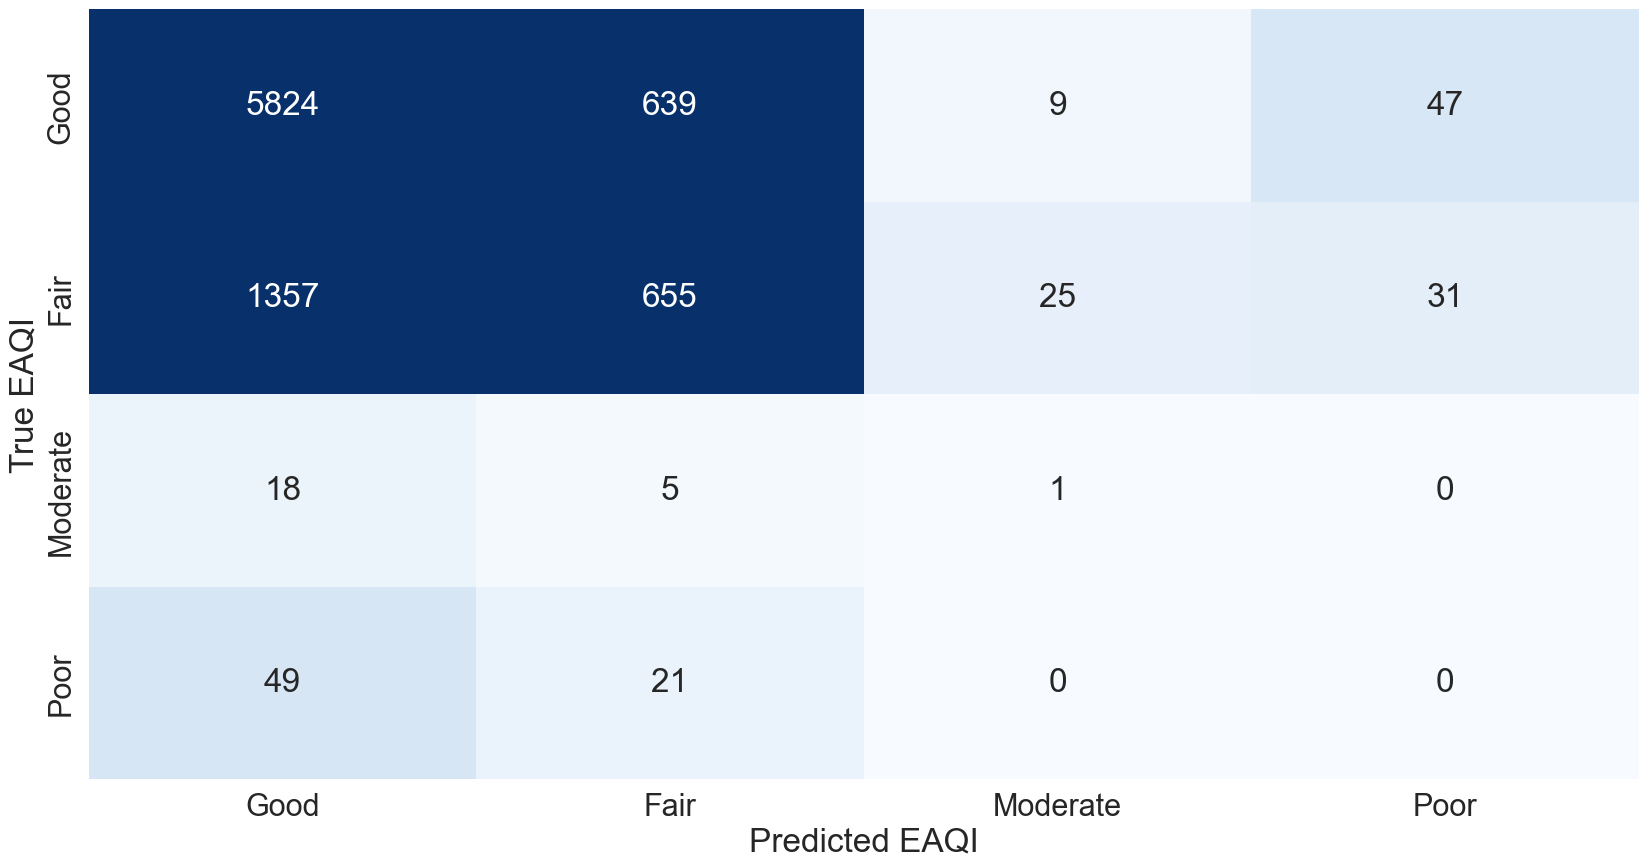

In [6]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = ["Good","Fair","Moderate","Poor"],
                  columns = ["Good","Fair","Moderate","Poor"],)
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
sns.heatmap(df_cm, annot=True, fmt="", cmap='Blues', cbar=False, vmax=300)
plt.ylabel('True EAQI')
plt.xlabel('Predicted EAQI')


### Model for 2021 no Cars


In [7]:
if(no_AQI):
    X_data = data[X_labels]

    X_data[["Personenwagen", "Lastwagen"]] = 0

    y_data = data[y_label]
    X, y = create_windows(X_data, y_data, 48)

    test_data = SeqDataset(X, y)

    loaded_data = DataLoader(test_data, batch_size=1, shuffle=False)

    model = LSTM_Model()
    model.load_state_dict(torch.load(PATH))

    model = model.to(torch.double)

    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for j, (xi, yi) in enumerate(loaded_data):
            y_predicted = model(xi)
            y_pred.append(np.argmax(y_predicted.numpy()))
            y_true.append(np.argmax(yi.numpy()))



C:\Users\Luca\AppData\Local\Temp\ipykernel_7848\2725327972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[["Personenwagen", "Lastwagen"]] = 0


In [8]:
Counter(y_pred)

Counter({0: 8651, 1: 17, 3: 11, 2: 2})

In [9]:
from torchsummary import summary
model = LSTM_Model()
model = model.double()

from torch.utils.tensorboard import SummaryWriter
summary(model, input_size=(48,10))


writer=SummaryWriter('/content/logsdir')


ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
# model = LSTM_Model()
# model = model.to(torch.double)
# model.eval()
# model.load_state_dict(torch.load(PATH))


# X_labels = ['Zweirad', 'Personenwagen', 'Lastwagen', 'Hr', 'RainDur', 'T', 'WVs', 'StrGlo', 'p', "AQI"] 
# y_label = "AQI"

# data = pd.read_csv('../processed_data/full_data_imputed_with_EAQI.csv')

# data = data.loc[data["Jahr"]== 2021]

# X_data = data[X_labels]
# y_data = data[y_label]

# X, y = create_windows(X_data, y_data, 48)


# y_true = []
# y_pred = []
# score = []
# for i, yi in enumerate(y):
#     data_point = SeqDataset([X[i]], [yi])
#     loaded_point = DataLoader(data_point, batch_size=1, shuffle=False)
#     with torch.no_grad():
#         for j, (xj, yj) in enumerate(loaded_point):
#             y_predicted = model(xj)
#             yi_pred = np.argmax(y_predicted.numpy())
#             y_pred.append(yi_pred)
#             y_true.append(np.argmax(yj.numpy()))
#             if(i+1 != len(y)):
#                 X[i+1, -1, -1] = yi_pred
#             score.append(accuracy_score(y_true, y_pred))

# plt.plot(score)
# print(y_true[:20])
# print(y_pred[:20])
# print(score[:20])
